In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp

from icecream import ic

from msfm.utils import tfrecords, survey, pipelines
from msfm.utils.input_output import read_yaml

In [3]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

# repo_dir = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model"
repo_dir = "/Users/arne/git/multiprobe-simulation-forward-model"
# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v1/fiducial/DESy3_fiducial_???.tfrecord"
tfr_pattern = "/Users/arne/data/DESY3/tfrecords/v1/DESy3_fiducial_000.tfrecord"
pert_labels = conf["analysis"]["fiducial"]["perturbations"]["labels"][:7]

ic(pert_labels)

ic| pert_labels: ['fiducial',
                  'delta_Aia_m',
                  'delta_Aia_p',
                  'delta_H0_m',
                  'delta_H0_p',
                  'delta_Ob_m',
                  'delta_Ob_p']


['fiducial',
 'delta_Aia_m',
 'delta_Aia_p',
 'delta_H0_m',
 'delta_H0_p',
 'delta_Ob_m',
 'delta_Ob_p']

In [7]:
dset = pipelines.get_train_dset(conf, repo_dir, tfr_pattern, pert_labels, i_noise=0, batch_size=3, examples_shuffle_buffer=7, n_readers=1, n_prefetch=1, eval_seed=2)

for x in dset.take(1):
    # kg_perts, index = x
    print(type(x))
    data_vectors = x[0]
    index = x[1]
    # print(x[0]["kg_fiducial"].shape)
    # print(x[0].keys())
    # # print(x.keys())
    # # print(x["kg_fiducial"])
    # data_vectors = x[0]


23-02-06 13:59:24    survey.py INF   Loaded pixel file 
Cause: could not parse the source code of <function get_train_dset.<locals>.<lambda> at 0x29228b010>: no matching AST found among candidates:
# coding=utf-8
lambda example: tfrecords.parse_inverse_fiducial(example, pert_labels, i_noise, n_data_vec_pix, n_z_bins)
# coding=utf-8
lambda data_vectors, index: dset_remove_mean(data_vectors, index, pert_labels, mean_corr_fac)
# coding=utf-8
lambda data_vectors, index: dset_add_noise(data_vectors, index, pert_labels)
# coding=utf-8
lambda data_vectors, index: dset_concat_perts(data_vectors, index, pert_labels)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function get_train_dset.<locals>.<lambda> at 0x29228b010>: no matching AST found among candidates:
# coding=utf-8
lambda example: tfrecords.parse_inverse_fiducial(example, pert_labels, i_noise, n_data_vec_pix, n_z_bins)
# coding=utf-8
lambda data_v

In [5]:
dset

<PrefetchDataset element_spec=(TensorSpec(shape=(21, 463872, 4), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.int64, name=None))>

In [27]:
from time import time
import matplotlib.pyplot as plt

In [26]:
t0 = time()
delta_t = []
for x in dset.take(100):
    t1 = time()
    delta_t.append(t0 - t1)
    t0 = t1



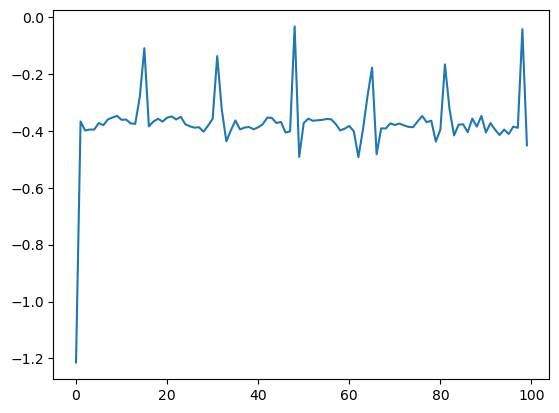

In [28]:
plt.plot(delta_t)

In [10]:
data_vectors.keys()

dict_keys(['kg_fiducial', 'kg_delta_Aia_m', 'kg_delta_Aia_p', 'kg_delta_H0_m', 'kg_delta_H0_p', 'kg_delta_Ob_m', 'kg_delta_Ob_p', 'sn'])

In [12]:
data_vectors[f"kg_fiducial"].shape

TensorShape([3, 463872, 4])

In [14]:
result = tf.concat([data_vectors[f"kg_{pert_label}"] for pert_label in pert_labels], axis=0)

In [15]:
result.shape

TensorShape([21, 463872, 4])

In [11]:
[f"kg_{pert_label}" for pert_label in pert_labels]

['kg_fiducial',
 'kg_delta_Aia_m',
 'kg_delta_Aia_p',
 'kg_delta_H0_m',
 'kg_delta_H0_p',
 'kg_delta_Ob_m',
 'kg_delta_Ob_p']

In [ ]:
[data_vectors[f"kg_perts"]]

# plotting

In [19]:
pix_file = "../../data/DESY3_pixels_512.h5"
with h5py.File(pix_file, "r") as f:
    data_vec_pix = f["metacal/map_cut_outs/data_vec_ids"][:]
    non_tomo_patches_pix = f["metacal/masks/RING/non_tomo"][:]
    
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

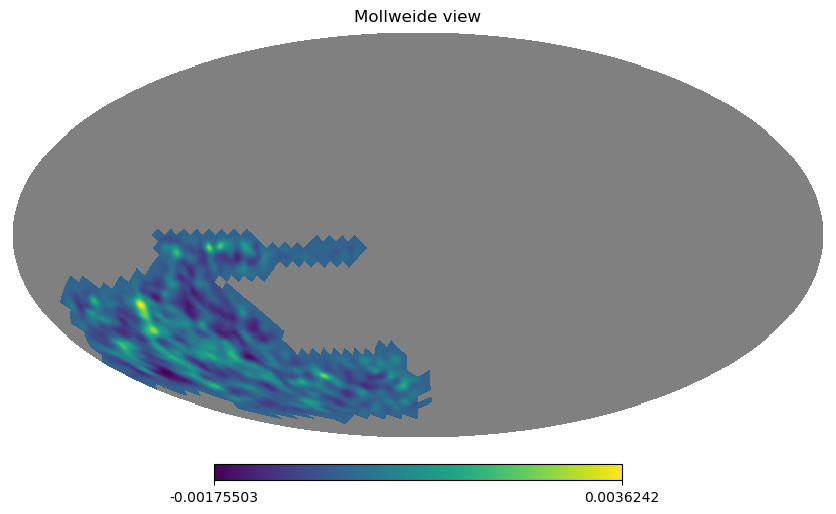

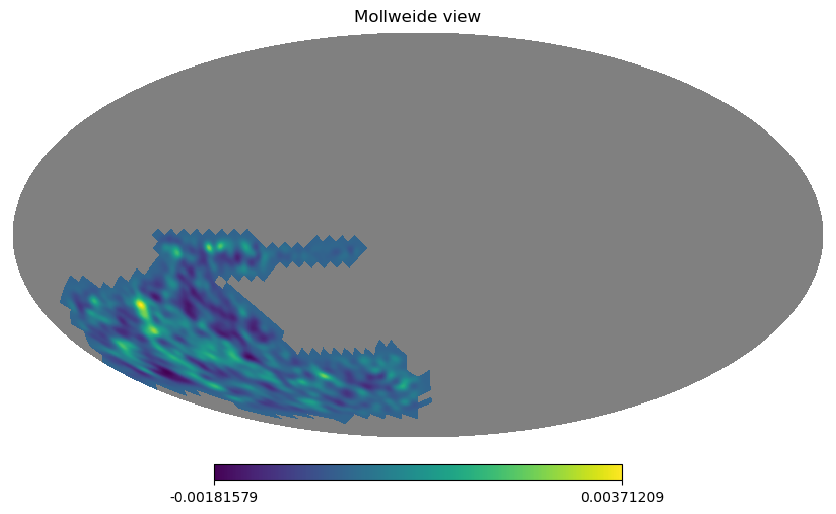

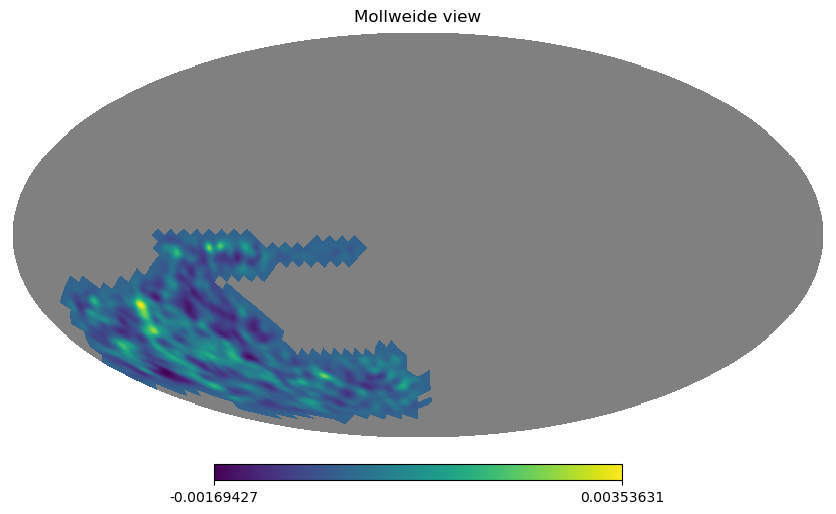

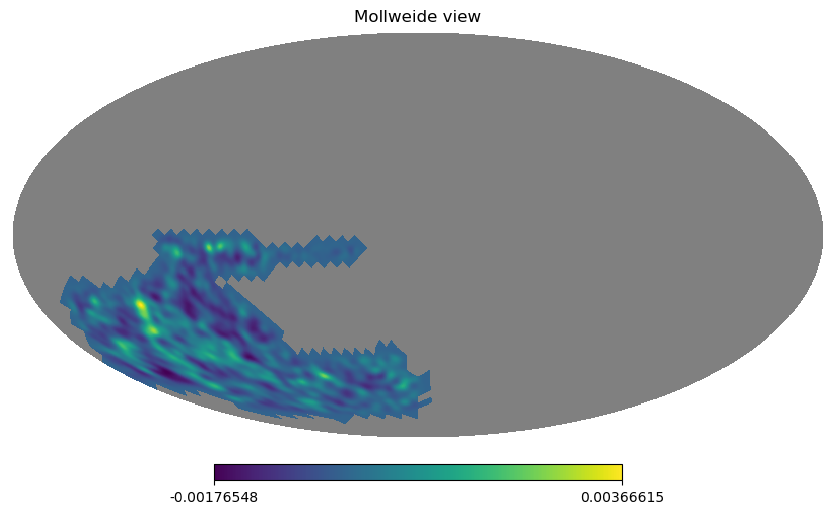

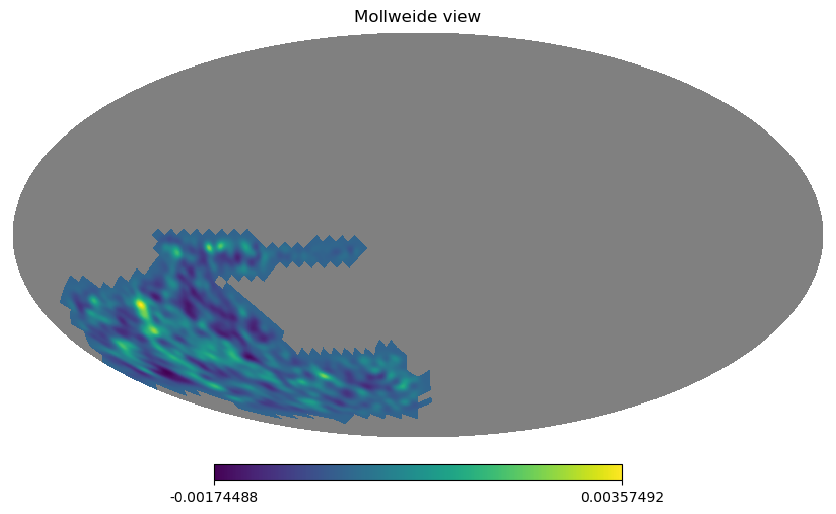

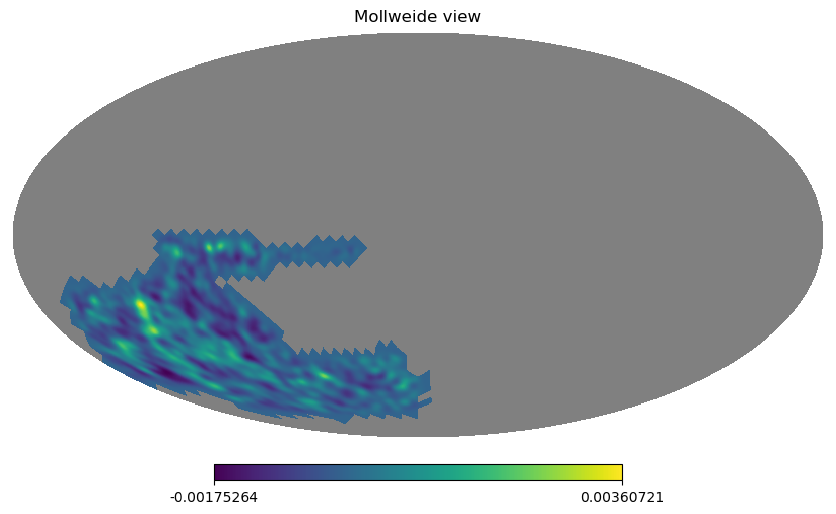

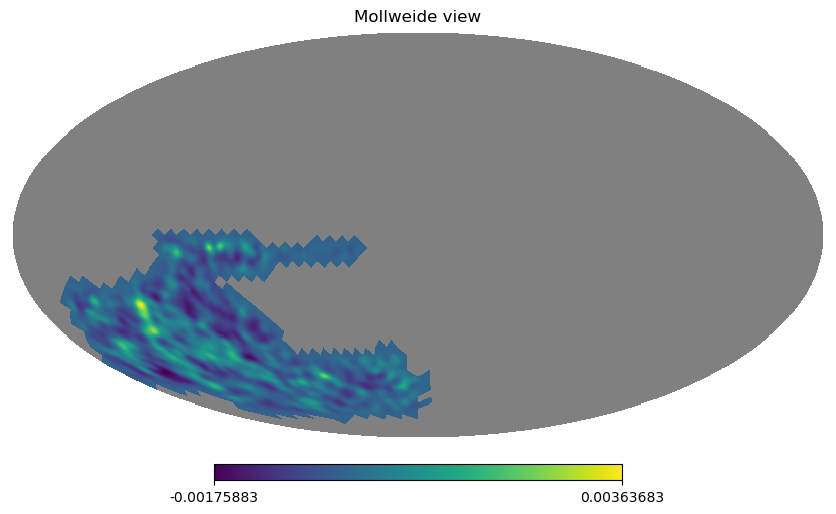

In [22]:
# kg = x["kg_fiducial"].numpy()
# print(kg.shape)

for i, kg in enumerate(result):
    if i % 3 == 0:
        kg = kg.numpy()
        i_batch = 0
        i_pert = 0
        i_tomo = 0

        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = kg[:, i_tomo]

        # hp.mollview(hp_map, nest=True)

        hp_map_ring = hp.pixelfunc.reorder(hp_map, inp="NESTED", out="RING")
        hp_smoothed = hp.sphtfunc.smoothing(hp_map_ring, fwhm=0.05)
        hp.mollview(hp_smoothed)

        # # hp_smoothed = hp.sphtfunc.smoothing(hp_map, fwhm=0.01, nest=True)
        # # hp.mollview(hp_smoothed, nest=True)

        # padding = np.full(n_pix, hp.UNSEEN)
        # padding[hp_map==0] = 1
        # hp.mollview(padding, nest=True)


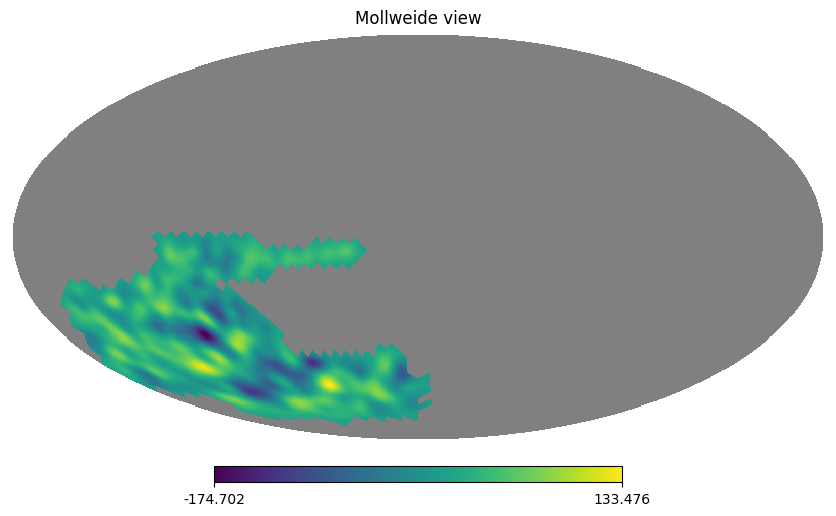

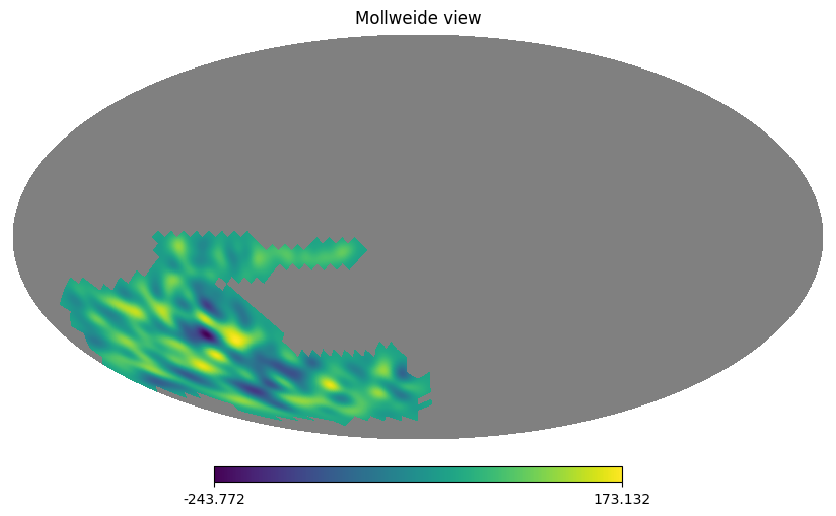

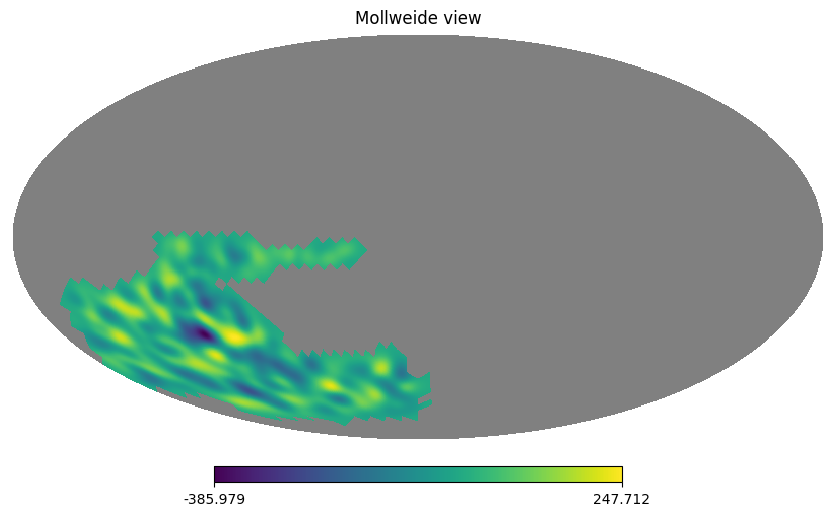

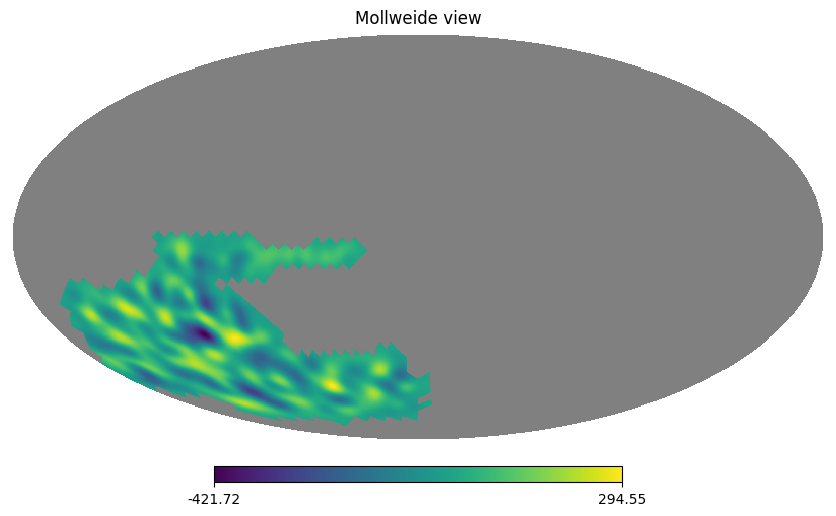

In [50]:
i_batch = 4
i_pert = 0

for i_tomo in range(4):
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg_perts_np[i_batch, i_pert, :, i_tomo]

    # hp.mollview(hp_map, nest=True)

    hp_map_ring = hp.pixelfunc.reorder(hp_map, inp="NESTED", out="RING")
    hp_smoothed = hp.sphtfunc.smoothing(hp_map_ring, fwhm=0.1)
    hp.mollview(hp_smoothed)

    # hp_smoothed = hp.sphtfunc.smoothing(hp_map, fwhm=0.01, nest=True)
    # hp.mollview(hp_smoothed, nest=True)

    # padding = np.full(n_pix, hp.UNSEEN)
    # padding[hp_map==0] = 1
    # hp.mollview(padding, nest=True)
